#### SCRIPT TO EXTRACT VLA HI PROFILES FROM DATACUBES
Notebook must be placed in `HCG_CUBES_PROP` directory that can be downloaded from amiga server

In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import sys
import os
import warnings
from astropy.utils.exceptions import AstropyWarning

### Quiet down Astropy warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [11]:
### HCG ID for which to extract the spectrum from the VLA datacube (16, 30, 31, 90, 97)
hcg_no = 16

In [12]:
### Utility functions
def beamArea(hdr):
    bmaj = hdr['BMAJ'] * 3600.0
    bmin = hdr['BMIN'] * 3600.0
    cellx  = 3600. * np.abs(hdr['CDELT1'])
    celly  = 3600. * np.abs(hdr['CDELT2'])
    cellArea = cellx * celly
    fac  = np.pi / (4.0 * np.log(2.0))
    bArea = fac * bmaj * bmin
    return bArea / cellArea

def vrad2vopt(vrad):
    '''To convert radio velocity to optical velocity'''
    c = 299792458.0 # m/s
    freq0 = 1420405751.768 # Hz
    freq = freq0 * (1. - (1.e3*vrad)/c)
    return 1.e-3 * c/freq * (freq0 - freq)

In [22]:
### Where to find the VLA cube and mask, and the GBT spectrum
inpfits  = 'HCG%s/HCG%s_HI.fits' %(hcg_no,hcg_no)         ### input FITS
maskfile = 'HCG%s/HCG%s_mask.fits' %(hcg_no,hcg_no)       ### input mask
gbt_spec = 'GBT_spectra_B10/GBT_HCG%s.csv' %hcg_no

### If you wish to define a region, do it here in ['hh:mm:ss', 'dd:mm:ss'] format
blc = [] #['02:10:38.0', '-10:26:00.0']
trc = [] #['02:08:30.0', '-09:55:00.0']

hdu = fits.open(inpfits)
hdr  = hdu[0].header
data = hdu[0].data
hdu.close()
if maskfile:
    maskhdu = fits.open(maskfile)
    mask = maskhdu[0].data
    maskhdu.close()
    
dv = hdr['CDELT3'] * 1.e-3  ### Velocity width in km/s
c0 = hdr['CRPIX3']          ### Reference velocity pixel
v0 = hdr['CRVAL3'] * 1.e-3  ### Velocity of reference pixel in km/s

nz, nx, ny = data.shape

wcs = WCS(hdr)
wcs = wcs.sub(['celestial'])

if (blc or trc):
    try:
        blclim = SkyCoord(blc[0], blc[1], unit=(u.hourangle, u.deg))
        trclim = SkyCoord(trc[0], trc[1], unit=(u.hourangle, u.deg))
        xmin, ymin = wcs.wcs_world2pix(blclim.ra.deg,blclim.dec.deg,1)
        xmax, ymax = wcs.wcs_world2pix(trclim.ra.deg,trclim.dec.deg,1)
    except:
        print("I cannot understand the boundaries you fixed, please use the ['h:m:s', 'd:m:s'] format.\nI will ignore the boundaries...")
        xmin, ymin = 0, 0
        xmax, ymax = nx-1, ny-1
else:
    xmin, ymin = 0, 0
    xmax, ymax = nx-1, ny-1

area  = beamArea(hdr)

vlist = []
fluxList = []

if not maskfile:
    mask = data

for k in range(nz):
    if not np.isnan(mask[k]).all():
        flux = 0.0
        for i in range(int(xmin),int(xmax)):
            for j in range(int(ymin),int(ymax)):
                if not (np.isnan(mask[k,i,j]) or mask[k,i,j] == 0.):
                    flux += data[k,i,j]
    else:
        flux = 0.0
    vk = v0 + (k - c0) * dv
    vlist.append(vk)
    fluxList.append(flux/area)
    print('\r','Plane %d/%d done...' %(k+1,nz), end='', flush=True)
print('\nDone!')

varray = np.array(vlist)
if hdr['CTYPE3'].upper() == 'VRAD':
    varray = vrad2vopt(varray)
fluxarray = np.array(fluxList)

if not os.path.isdir('HIprofiles'):
    os.mkdir('HIprofiles')
np.savetxt('HIprofiles/HIprofile-%s.txt' %(inpfits.split('/')[0]), np.c_[varray,fluxarray], header='velocity & flux')

 Plane 63/63 done...
Done!


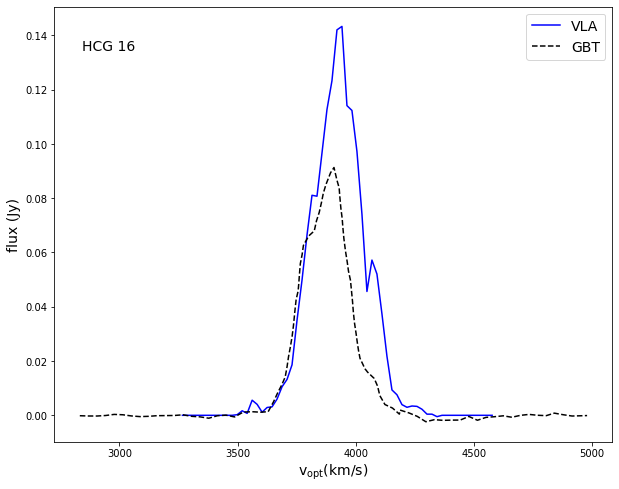

In [18]:
gbt_data = pd.read_csv(gbt_spec, names=['velocity', 'flux'])
gbt_v, gbt_f = gbt_data['velocity'], gbt_data['flux']
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.plot(varray, fluxarray, 'b-', label='VLA')
plt.plot(gbt_v, gbt_f, 'k--', label='GBT')
plt.xlabel(r'$\rm v_{opt} (km/s)$', size=14)
plt.ylabel('flux (Jy)', size=14);
plt.text(0.05, 0.9, 'HCG %s' %hcg_no, size=14, transform=ax.transAxes)
plt.legend(loc='upper right', fontsize=14);

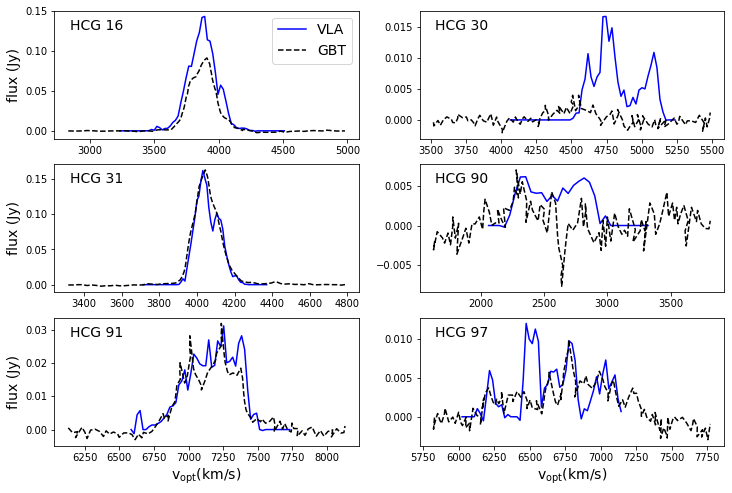

In [21]:
hcgs = [16, 30, 31, 90, 91, 97]
fig, axs = plt.subplots(3,2, figsize=(12,8))
k = 0
for iax in range(3):
    for jax in range(2):
        vla_spec = np.loadtxt('HIprofiles/HIprofile-HCG%s.txt' %hcgs[k], unpack=True, comments='#')
        gbt_data = pd.read_csv('GBT_spectra_B10/GBT_HCG%s.csv' %hcgs[k], names=['velocity', 'flux'])
        axs[iax,jax].plot(vla_spec[0],vla_spec[1], 'b-', label='VLA')
        axs[iax,jax].plot(gbt_data['velocity'], gbt_data['flux'], 'k--', label='GBT')
        axs[iax,jax].text(0.05, 0.85, 'HCG %s' %hcgs[k], size=14, transform=axs[iax,jax].transAxes)
        if iax == 2:
            axs[iax,jax].set_xlabel(r'$\rm v_{opt} (km/s)$', size=14)
        if jax == 0:
            axs[iax,jax].set_ylabel('flux (Jy)', size=14)
        axs[0,0].legend(loc='upper right', fontsize=14);
        k += 1
plt.savefig('HCG-spectra.pdf')